In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
import mkl
mkl.set_num_threads(1)

48

In [3]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
%run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
%run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.
icecube (full) astro events: 2671.270969525108
Below 57.14 deg, A_eff is set to 0
starting aeff rotations
Saving up-going effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_upgoing.pckl
starting full effective area calculation...
Saving full effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_full.pckl
finished!
Flux will be saved to: /home/hpc/capn/capn102h/repos/Plenum/resources/MCEq_flux.pckl
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for 

# Imports

In [5]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import LOCALPATH, BASEPATH, sigma1, sigma3, sigma5
import settings as st
from tools import array_source_interp, poisson_llh, get_scaler
from tqdm import tqdm

# Settings

In [6]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

# helper functions

In [7]:
def scaling_estimation(
    df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5
):
    """Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors"""

    # start with two values for the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new

    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1

    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong
        # some random value to get started again
        print("scaling went wrong:", scaler_new)
        scaler_new = np.random.uniform(1.5, 3.5) / df.iloc[-1]["SosB"]

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [8]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

# Atmospheric background
Actually, we would need to account for the different zenith regions of a source, if the detector is not at one of the poles.
This is currently not yet implemented

In [9]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [10]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


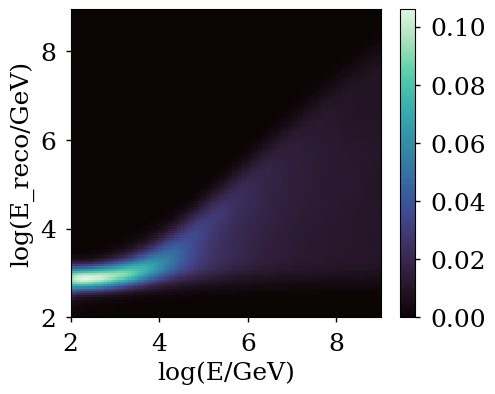

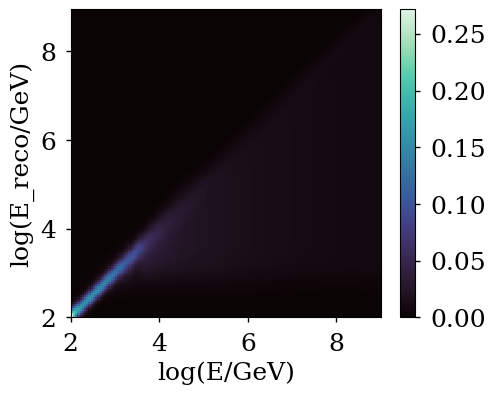

In [11]:
# full range, easy plotting
baseline_eres.plot()
improved_eres.plot()

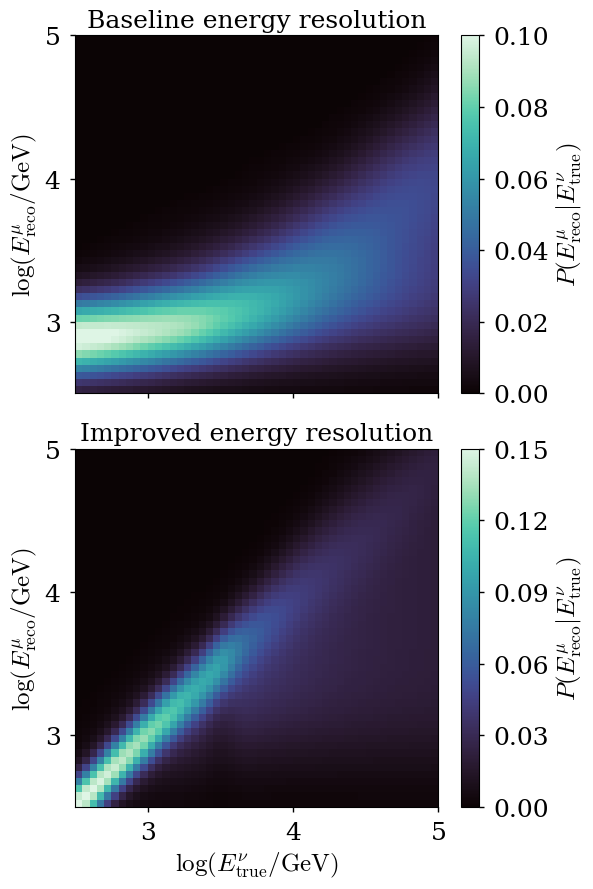

In [12]:
ebounds = (2.5, 5)

f, axes = plt.subplots(nrows=2, figsize=(6, 9), sharex=True)
f, ax = mephisto.plot_mephistogram(baseline_eres, f=f, ax=axes[0], vmin=0, vmax=0.1,
    linewidth=0,
    rasterized=True,)
ax.set_xlabel("")
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.collections[0].colorbar.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
ax.set_title("Baseline energy resolution")
ax.set_yticks([3, 4, 5])

f, ax = mephisto.plot_mephistogram(improved_eres, f=f, ax=axes[1], vmin=0, vmax=0.15,
    linewidth=0,
    rasterized=True,)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.set_xlabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
cb = ax.collections[0].colorbar
cb.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
cb.set_ticks(np.arange(0, 0.16, step=0.03))
ax.set_title("Improved energy resolution")
ax.set_yticks([3, 4, 5])

f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/energy_resolution_comparison.pdf"))

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [13]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

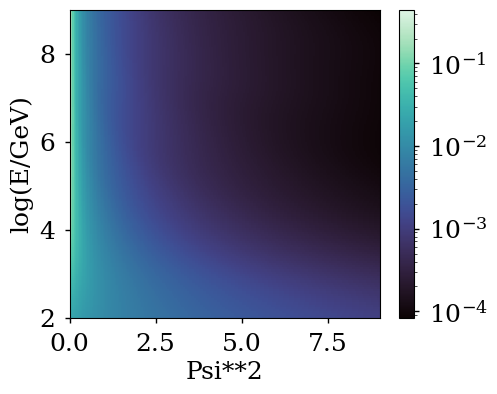

In [14]:
e_psi2_grid.plot(norm=LogNorm())

# Flux definition

In [15]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 source parameters

In [16]:
from settings import PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME

In [17]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

In [18]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

## Check event numbers

In [19]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10**aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85

ngc 1068: 88.11995357633094


## PL+Cut: source parameters

In [20]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
Gamma_cut = 2.0
logE_cut = 3.5  # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff")


### scale the fluxes such that the event numbers match


In [21]:
## event numbers for IceCube based on NGC 1068 flux
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        10**aeff_factor_signal.bin_mids[1],
        baseline_eres,
        1,
        ngc_flux,
    )
)
print("IceCube expected number of events:", astro_ev_sum_pl)  # see above
# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        10**aeff_factor_signal.bin_mids[1],
        baseline_eres,
        1,
        tmp_flux,
    )
)
# calculate the flux normalization so that event numbers match für IceCube
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("Need to scale the PL+cutoff flux by:", flux_scaling_cut, "(flux_scaling_cut)")
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
)

IceCube expected number of events: 88.11995357633094
Need to scale the PL+cutoff flux by: 1.4514517646567837 (flux_scaling_cut)
flux normalization before 5e-14 after 7.257258823283919e-14


### Plot 1D analysis slice histograms

# source $\nu_\mu$ : 88.1
# atmo. $\nu_\mu$ : 1200.9 (within 28 deg²)
# source $\nu_\mu$ : 88.1
# atmo. $\nu_\mu$ : 1200.9 (within 28 deg²)


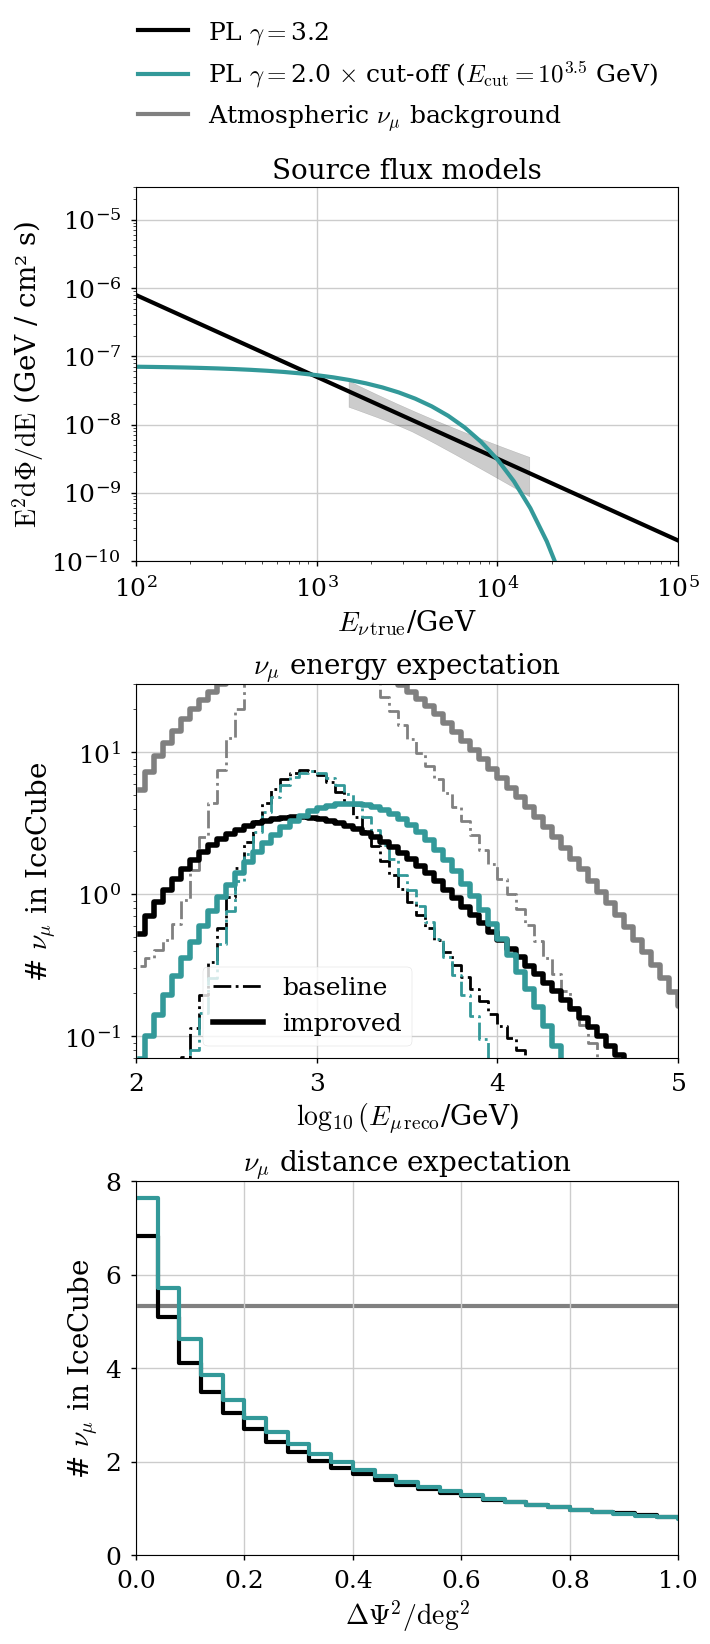

In [22]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(nrows=3, figsize=(7, 19))
ax = axes[0]
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"PL $\gamma=${Gamma_cut} $\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{logE_cut:1.1f}}}$ GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    10**aeff_factor_signal.bin_mids[1],
    array_source_interp(
        ngc_src_config["dec"], bckg_histo["IceCube"], bckg_histo["IceCube"].bin_mids[0], axis=1
    )
    * sq_deg
    * (10**aeff_factor_signal.bin_mids[1]**y_scaling),
    label=r"Atmospheric $\nu_\mu$ background",
    color="gray",
    lw=3,
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 3e-5)
ax.set_xlim(1e2, 1e5)
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 0.93),
)


### plot Event numbers in E_reco
ii = 0
evals = baseline_eres.bin_mids[1]
ax = axes[1]
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], bckg_histo["IceCube"].bin_mids[0], axis=1
        ),
        energy_resolution=eres,
    )

    # power law
    k_s_pl = astro_flux(
        aeff_factor_signal,
        10**aeff_factor_signal.bin_mids[1],
        eres,
        1,
        ngc_flux,
    )

    # cutoff
    k_s_cut = astro_flux(
        aeff_factor_signal,
        10**aeff_factor_signal.bin_mids[1],
        eres,
        1,
        ngc_cut_flux,
    )

    ax = axes[1]
    ax.plot(
        evals,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid",
        label=e_name,
        color="k",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        evals,
        k_s_cut.sum(axis=0),
        drawstyle="steps-mid",
        color="#339999",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        evals,
        k_b.sum(axis=0),
        drawstyle="steps-mid",
        color="gray",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )
    print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_yscale("log")
ax.set_xlim(2, 5)
ax.set_ylim(7e-2, 3e1)
ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
ax.set_xticks([2, 3, 4, 5])

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_cut.sum(axis=1)]),
    drawstyle="steps-mid",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    color="gray",
    lw=3,
    zorder=0,
)

ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

f.savefig(
    join(BASEPATH, f"plots/ngc_paper/ngc_spectral_improved_dpsi.pdf"),
    bbox_inches="tight",
)

# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [23]:
def ps_llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_flux,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):
    """
    Calculate the log-likelihood using Poisson statistics for a single dataset assuming consistent properties.

    Parameters:
        x (list): Fit parameters.
            x[0]: Background normalization scaling.
            x[1]: Signal normalization scaling.
            x[2:]: Other signal parameters. See 'astro_flux' for further shapes and parameters.
        aeff_factor_s (float): Effective area factor for the signal.
        aeff_factor_b (float): Effective area factor for the background.
        bckg_flux (list): Background flux values.
        k_i (array-like): Observation/Asimov data.
        energy_resolution (float): Energy resolution.
        e_0 (float): Normalization energy. Default value is E0_NGC.
        phi_0 (float): Normalization flux. Default value is PHI_NGC.
        shape (str): Flux shape.
        verbose (bool, optional): Whether to print additional information. Default is False.

    Returns:
        float: -2 * Log-likelihood value calculated using Poisson statistics. See 'poisson_llh'.

    Note:
        This function assumes that there is only one dataset with consistent properties.
    """
    # Calculate the background contribution
    mu_b = (
        atmo_background(
            aeff_factor=aeff_factor_b,
            bckg_vals=bckg_flux,
            energy_resolution=energy_resolution,
        )
        * x[0]
    )
    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        10**aeff_factor_signal.bin_mids[1],
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


def ps_llh_multi(
    x,
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_bckg_flux,
    all_k,
    all_eres,
    shape,
    e_0,
    phi_0,
):
    """
    Calculate the total log-likelihood across multiple datasets with different properties.

    Parameters:
        x (list): Fit parameters.
        all_aeff_factor_s (list): List of effective area factors for the signal for each dataset.
        all_aeff_factor_b (list): List of effective area factors for the background for each dataset.
        all_bckg_flux (list): List of background flux values for each dataset.
        all_k (list): List of observation/Asimov data for each dataset.
        all_eres (list): List of energy resolutions for each dataset.
        shape (str): Flux shape.
        e_0 (float): Normalization energy.
        phi_0 (float): Normalization flux.

    Returns:
        float: Total log-likelihood value across all datasets.

    Note:
        This function assumes that there are multiple datasets with different properties.
    """
    llh = 0
    for i, aeffs in enumerate(all_aeff_factor_s):
        llh += ps_llh_single(
            x=x,
            aeff_factor_s=aeffs,
            aeff_factor_b=all_aeff_factor_b[i],
            bckg_flux=all_bckg_flux[i],
            k_i=all_k[i],
            energy_resolution=all_eres[i],
            e_0=e_0,
            phi_0=phi_0,
            shape=shape,
        )
    return llh
def setup_multi_llh(eres, conf, bg_config, sig_config, src_flux=ngc_flux, verbose=False, return_s_b=False):
    """
    Set up the components required for calculating the log-likelihood across multiple datasets.

    Parameters:
        eres (dict or array): Dictionary of arrays/mephistograms or single array/mephistogram representing the
                                  energy resolutions for each dataset. If a dictionary is provided,
                                  it should map dataset identifiers to their corresponding energy resolution.
                                  If a float is provided, the same energy resolution will be used for all datasets.
        conf (tuple): Tuple containing two lists - the first list represents dataset identifiers,
                      and the second list contains corresponding scaling factors corresponding to
                      either a lifetime scaling or effective-area scaling.
        verbose (bool, optional): Whether to print additional information. Default is False.
        return_s_b (bool, optional): Whether to return the individual signal and background histograms. Default is False.

    Returns:
        tuple: A tuple containing the following components for each dataset:
            - all_aeff_factor_s (list): List of effective area factors for the signal.
            - all_aeff_factor_b (list): List of effective area factors for the background.
            - all_k (list): List of observation/Asimov data.
            - all_bckg_flux (list): List of background flux values.
            - if return_s_b: all_k_s, all_k_b (lists): List of signal and background histograms

    Note:
        This function assumes that the configuration parameters and required functions (e.g., `calc_aeff_factor`,
        `atmo_background`, `astro_flux`, `array_source_interp`) are defined and accessible in the global namespace.
        If `eres` is a dictionary, each dataset identifier should have an associated energy resolution value.
        If `eres` is an  array/mephistogram, the same energy resolution will be used for all datasets.
    """

    all_aeff_factor_s = []
    all_aeff_factor_b = []
    all_k = []
    all_bckg_flux = []
    all_eres = []
    if return_s_b:
        all_k_s = []
        all_k_b = []

    for ident, factor in zip(*conf):
        # Calculate effective area factors for background and signal
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **bg_config) * factor
        aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **sig_config) * factor

        # Calculate background flux
        bckg_flux = array_source_interp(
            bg_config["dec"], bckg_histo[ident], bckg_histo["IceCube"].bin_mids[0], axis=1
        )
        # Determine the energy resolution for the current dataset
        current_eres = eres[ident] if isinstance(all_eres, dict) else eres

        # Calculate asimov data for atmospheric background
        k_b = atmo_background(
            aeff_factor=aeff_factor_bckg,
            bckg_vals=bckg_flux,
            energy_resolution=current_eres,
        )

        # Calculate asimov data for astrophysical signal with power law spectrum
        k_s = astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=10**aeff_factor_signal.bin_mids[1],
            energy_resolution=current_eres,
            phi_scaling=1,
            flux_shape=src_flux,  # powerlaw
        )

        if verbose:
            print("Asimov data sum:")
            print("Background:", np.sum(k_b))
            print("Signal:", np.sum(k_s))

        all_aeff_factor_s.append(aeff_factor_signal)
        all_aeff_factor_b.append(aeff_factor_bckg)
        all_k.append(k_s + k_b)
        all_bckg_flux.append(bckg_flux)
        all_eres.append(current_eres)
        if return_s_b:
            all_k_s.append(k_s)
            all_k_b.append(k_b)
    if return_s_b:
        return (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        )
    else:
        return all_aeff_factor_s, all_aeff_factor_b, all_k, all_bckg_flux, all_eres

# NGC 1068
## Significance test Background vs. Background + Signal

In [24]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)
    print("=" * 10)

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
    # asimov data
    bckg_flux = array_source_interp(
        ngc_src_config["dec"], bckg_histo["IceCube"], bckg_histo["IceCube"].bin_mids[0], axis=1
    )
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=bckg_flux,
        energy_resolution=baseline_eres,
    )
    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=10**aeff_factor_signal.bin_mids[1],
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=ngc_flux,  # powerlaw
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    dct = dict(
        shape="powerlaw",
        aeff_factor_b=aeff_factor_bckg,
        aeff_factor_s=aeff_factor_signal,
        bckg_flux=bckg_flux,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_single(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Asimov data sum:
Background: 1200.9125953382718
Signal: 88.11995357633094
Atmo-only normalization: [1.07336956]
Signal fit parameters: [1.  1.  3.2]
TS check: -321949.949597155 (fit:  -321949.949597155 )
-2 Delta LLH: 21.009300536243245
P-VALUE: 2.7408694753939735e-05 SIGNIFICANCE: 4.03407679520458

Plenum-1
Asimov data sum:
Background: 5005.487770022242
Signal: 370.15644658571745
Atmo-only normalization: [1.07394991]
Signal fit parameters: [1.  1.  3.2]
TS check: -289693.95727080334 (fit:  -289693.95727080334 )
-2 Delta LLH: 83.43455928069307
P-VALUE: 7.628087255681944e-19 SIGNIFICANCE: 8.787767167353353

Plenum-2
Asimov data sum:
Background: 12811.419639721007
Signal: 942.9361448318685
Atmo-only normalization: [1.07360136]
Signal fit parameters: [1.  1.  3.2]
TS check: -256293.18434335792 (fit:  -256293.18434335792 )
-2 Delta LLH: 219.97630031668814
P-VALUE: 1.709044265786738e-48 SIGNIFICANCE: 14.586600859488904



## multi llh with 2 sets

In [25]:
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        baseline_eres,
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.07336956]
Signal fit parameters: [1.  1.  3.2]
TS check: -321949.949597155 (fit:  -321949.949597155 )
-2 Delta LLH: 21.009300536243245
P-VALUE: 2.7408694753939735e-05 SIGNIFICANCE: 4.03407679520458

Plenum-1
Atmo-only normalization: [1.09869312]
Signal fit parameters: [1.  1.  3.2]
TS check: -1425175.622906541 (fit:  -1425175.622906541 )
-2 Delta LLH: 115.26337174815126
P-VALUE: 9.35140447985892e-26 SIGNIFICANCE: 10.426827868768687

Plenum-2


Atmo-only normalization: [1.08159519]
Signal fit parameters: [1.  1.  3.2]
TS check: -1383178.799426814 (fit:  -1383178.799426814 )
-2 Delta LLH: 253.32127681933343
P-VALUE: 9.817110160016711e-56 SIGNIFICANCE: 15.683435196783877



## 2D contour
### Grid scan

In [26]:
contour_formats = {
    "IceCube": {"colors": [st.poles["IceCube"]["color"]], "linestyles": "--"},
    "P-ONE": {"colors": [st.poles["P-ONE"]["color"]], "linestyles": ":"},
    "Plenum-1": {
        "colors": [st.poles["Plenum-1"]["color"]],
        "linestyles": st.poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [st.poles["Plenum-2"]["color"]],
        "linestyles": st.poles["Plenum-2"]["ls"],
    },
}
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
for key, eres_key in product(detector_keys, energy_reso):
    conf = st.detector_configurations[key]
    print(key, conf, eres_key)

IceCube (['IceCube'], [1]) baseline
IceCube (['IceCube'], [1]) improved
P-ONE (['IceCube', 'P-ONE'], [1, 1]) baseline
P-ONE (['IceCube', 'P-ONE'], [1, 1]) improved
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) baseline
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) improved
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) baseline
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) improved


In [27]:
energy_reso = {"baseline": baseline_eres, "improved": improved_eres}
step = 0.05
gamma_astro = np.arange(2.7, 4, step=step)
astro_scaling = np.arange(0.4, 1.6, step=step)
if True:
    tmp_SPL = []

    # loop over detector_configurations and energy resolutions
    for ident, eres_key in product(detector_keys, energy_reso):
        conf = st.detector_configurations[ident]
        print("info:", ident, conf, eres_key)
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            energy_reso[eres_key],  # select one resolution for all data sets
            conf,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config
        )

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )

        global_llh = lambda x: ps_llh_multi(x, **dct)
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )

        if out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", out[0])

        tmp = dict()
        tmp["LLH"] = "global"
        tmp["energy_res"] = eres_key
        tmp["ident"] = ident

        tmp["ts"] = out[1]
        tmp["conv"] = out[0][0]
        tmp["phi_astro"] = out[0][1]
        tmp["gamma"] = out[0][2]
        tmp_SPL.append(tmp)

        print("starting local fits...")
        for jj, (aa, gg) in enumerate(product(astro_scaling, gamma_astro)):
            #if jj%int(len(astro_scaling) * len(gamma_astro)/5) == 0: print("it", jj)
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], aa, gg), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["energy_res"] = eres_key
            tmp["ident"] = ident

            tmp["ts"] = local_out[1]
            tmp["delta_ts"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["phi_astro"] = aa
            tmp["gamma"] = gg
            tmp_SPL.append(tmp)
    print("done")

    SPL_df = pd.DataFrame(tmp_SPL)
    SPL_df.to_pickle(join(LOCALPATH, "ngc_contour_spl.pickle"))

info: IceCube (['IceCube'], [1]) baseline
starting local fits...


info: IceCube (['IceCube'], [1]) improved
starting local fits...
info: P-ONE (['IceCube', 'P-ONE'], [1, 1]) baseline
starting local fits...
info: P-ONE (['IceCube', 'P-ONE'], [1, 1]) improved
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) baseline
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) improved
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) baseline
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) improved
starting local fits...
done


In [28]:
import matplotlib

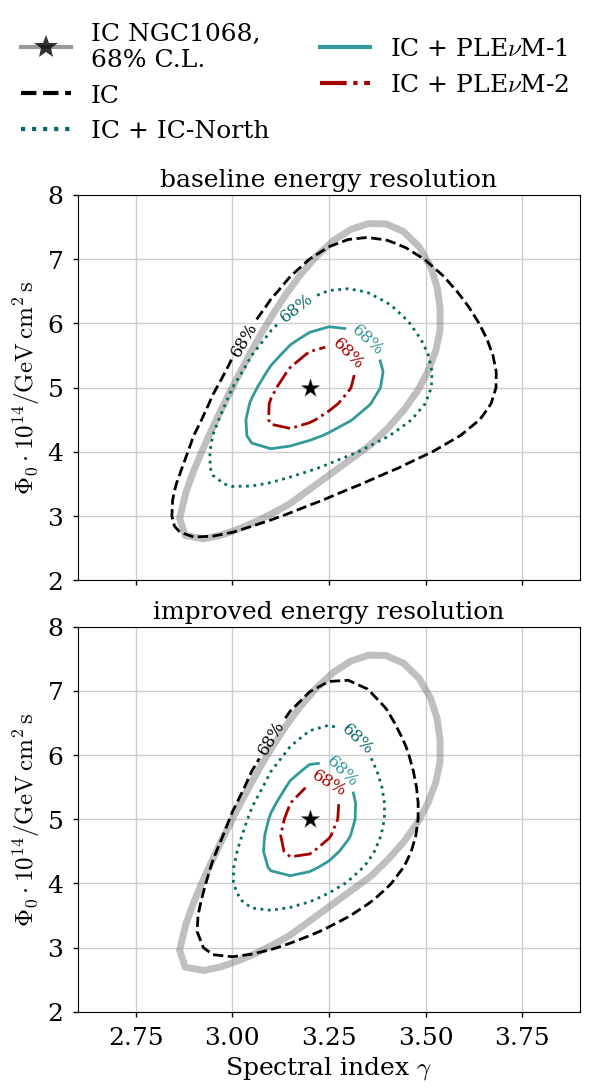

In [29]:
SPL_df = pd.read_pickle(join(LOCALPATH, "ngc_contour_spl.pickle"))
ref_color = "gray"

f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)

for ii, eres_key in enumerate(energy_reso):
    ax = axes[ii]
    ax.plot(
        gamma_c_68,
        phi_c_68 * 1e11,
        color=ref_color,
        ls="-",
        lw=5,
        alpha=0.5,
    )

    # draw contour levels
    cvals = [0.32]
    lbs = ["68%"]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = ax.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
            **contour_formats[ident],
        )
        fmt = {l: s for l, s in zip(sc.levels, lbs)}
        ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    # best fit
    ax.scatter(
        res_global.gamma.unique(),
        res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
        marker="*",
        s=200,
        color="k",
        edgecolor=ref_color,
    )

    ax.set_ylim(2, 8)
    ax.set_xlim(2.6, 3.9)
    ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
    ax.set_title(f"{eres_key} energy resolution")

ax.set_xlabel(r"Spectral index $\gamma$")

lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label="IC NGC1068,\n68% C.L.",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IC",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["P-ONE"]["colors"][0],
        ls=contour_formats["P-ONE"]["linestyles"],
        lw=3,
        label="IC + IC-North",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-2",
    ),
]
f.legend(
    handles=lines,
    loc="upper center",
    ncol=2,
    # fontsize="large",
    frameon=False,
)
# flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
# flux_str += r"= \Phi_0 \left( \frac{E}{\rm 1\,TeV} \right)^{-\gamma}$"
# ax.text(
#     2.65,
#     7.0,
#     flux_str,
#     fontsize=20,
#     bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
# )
# f.suptitle(f"NGC1068 contour", fontsize="xx-large")
f.tight_layout()
f.subplots_adjust(top=0.82)

f.savefig(join(BASEPATH, "plots/ngc_paper/2D_scan_ngc1068.pdf"))

### Translate contour to flux plot

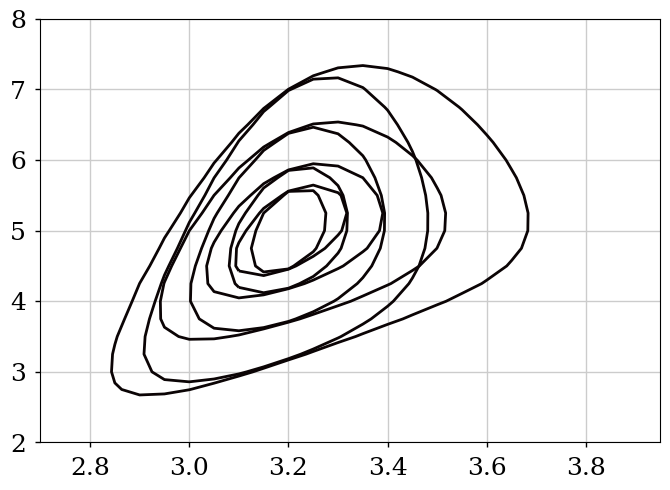

In [30]:
plenum_ngc_contours = []
for eres_key in energy_reso:
    # draw contour levels
    cvals = [0.32]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = plt.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
        )

        plenum_ngc_contours.append(
            {
                "energy_resolution": eres_key,
                "ident": ident,
                "level": levels[0],
                "contour": sc.allsegs[0][0],
            }
        )
plenum_ngc_contours = pd.DataFrame(plenum_ngc_contours)

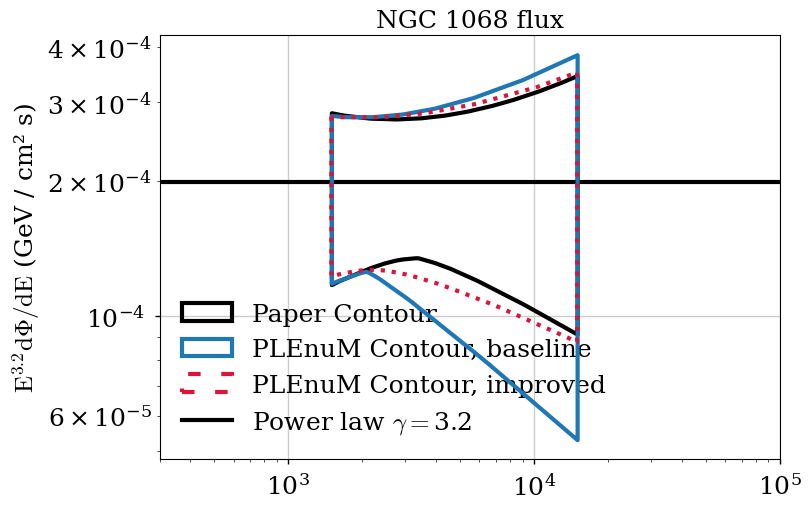

In [31]:
x_evals = np.logspace(0, 9, 100)
y_scaling = 3.2
f, axx = plt.subplots()

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
# paper reference contour
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


axx.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    edgecolor="k",
    facecolor=(0, 0, 0, 0),
    lw=3,
    zorder=15,
    label="Paper Contour",
)

# our contour
for eres_key in energy_reso:
    plenum_contour = plenum_ngc_contours.loc[
        (plenum_ngc_contours.energy_resolution == eres_key)
        & (plenum_ngc_contours.ident == "IceCube")
    ].contour.iloc[0]

    plenum_low = np.zeros_like(x_cont)
    plenum_high = np.zeros_like(x_cont)

    for ii, xe in enumerate(x_cont):
        tmp = power_law(
            xe, ngc_flux.E0, plenum_contour[:, 0], plenum_contour[:, 1] * 1e-14
        )
        plenum_low[ii] = np.min(tmp)
        plenum_high[ii] = np.max(tmp)
    axx.fill_between(
        x_cont,
        plenum_low * (x_cont**y_scaling),
        plenum_high * (x_cont**y_scaling),
        edgecolor="tab:blue" if eres_key == "baseline" else "crimson",
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
        ls="-" if eres_key == "baseline" else ":",
        label="PLEnuM Contour, " + eres_key,
    )

# power law flux
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
axx.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${ngc_flux.gamma}",
    color="k",
    alpha=1,
    zorder=10,
    lw=3,
)

# settings
axx.set_title("NGC 1068 flux")
axx.set_yscale("log")
axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV / cm² s)")
axx.set_xscale("log")
if y_scaling == 3:
    axx.set_ylim(3e-6, 1e-3)
elif y_scaling == 2:
    axx.set_ylim(1e-11, 1e-5)
axx.set_xlim(3e2, 1e5)
axx.legend(loc=0, frameon=False)
# very nice

## Disc. potential vs dec

In [32]:
thresholds = [sigma5]
detector_keys = [
    "IceCube" ,
    "P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]
decs = np.arange(-90, 91, step=5)

tmp = []  # save output here
for ident in detector_keys:
    conf = st.detector_configurations[ident]
    for dec in tqdm(np.deg2rad(decs)):
        if "IceCube" in ident and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["baseline"],  # select one resolution for all data sets
            conf,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_flux
        )
        # calculate an estimate for the flux scaling
        scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the 5-sigma discovery threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                shape="powerlaw",
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_flux.E0,
                phi_0=ngc_flux.norm,
            )
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_multi(x, **dct)

            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_flux.gamma),
                approx_grad=True,
            )

            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_b": np.sum(all_k_b),
                "n_sig": np.sum(current_k_s),
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_disc_pot.pickle"))

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:30<00:00,  1.21it/s]


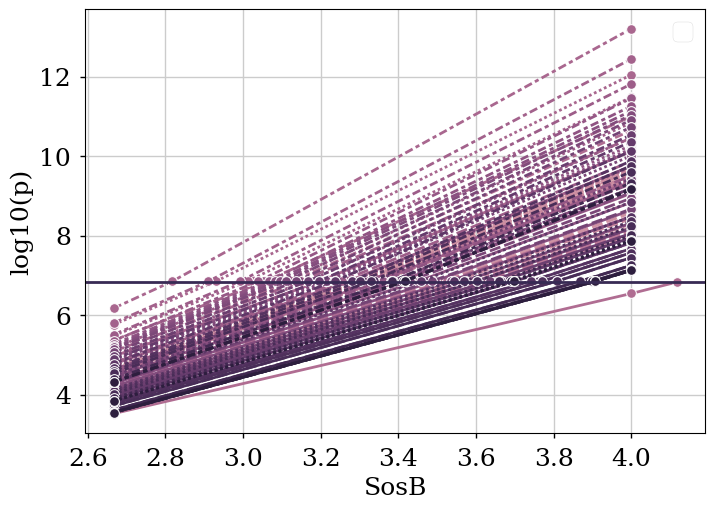

In [33]:
df = pd.DataFrame(tmp)
ax = sns.lineplot(data=df, y="log10(p)", x="SosB", hue="dec", marker="o", style="ident")
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)

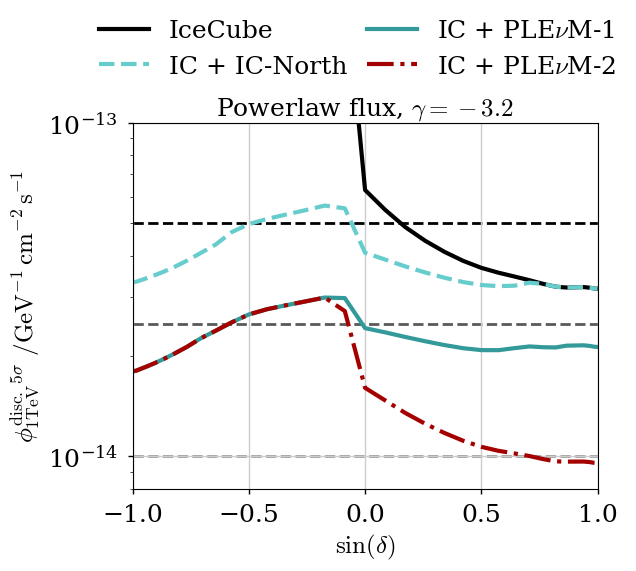

In [34]:
df = pd.read_pickle(join(LOCALPATH, "ngc_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5)) * PHI_NGC,
    columns=["disc5"],
).reset_index()

f, ax = plt.subplots(figsize=(6, 6))
for ident, series in flux.groupby("ident"):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]}
    )
ax.set_yscale("log")
ax.axhline(ngc_flux.norm, ls="--", lw=2, color="k", zorder=0)
ax.axhline(ngc_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
ax.axhline(ngc_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
ax.set_ylim(8e-15, 1e-13)
ax.set_xlim(-1, 1)
f.subplots_adjust(top=0.72)
ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")

f.savefig(join(BASEPATH, "plots/ngc_paper/ngc_disc_pot.pdf"), bbox_inches="tight")

# Power law vs. Power-law with cutoff
## normal vs. improved E resolution

In [35]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
detector_conf = [{"key": k, "identifier": det_plotting[k]["label"]} for k in idents]

eres_conf = (
    {"e_file": e_res_files["baseline"], "e_name": "Baseline"},
    {"e_file": e_res_files["1:1"], "e_name": "Removed bias"},
    #{"e_file": e_res_files["improved-20"], "e_name": "20% improv."},
    {"e_file": e_res_files["improved-50"], "e_name": "50% improv."},
)
# livetime relative to 10yrs

eres_detector_configurations = []
for dc, eresc in product(detector_conf, eres_conf):
    eres_detector_configurations.append(dc | eresc)
eres_detector_configurations = pd.DataFrame(eres_detector_configurations)

eres_detector_configurations

,key,identifier,e_file,e_name
0,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
1,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
2,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
3,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
4,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
5,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
6,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
7,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
8,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
9,Plenum-2,IC + PLE$\nu$M-2,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline


### Significance

In [36]:
pvals_ngc = []
for (identifier, es_ident), series in eres_detector_configurations.groupby(
    ["identifier", "e_name"], sort=False
):
    conf = st.detector_configurations[series.key.iloc[0]]
    print("info:", identifier, conf, es_ident)
    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        eres = pickle.load(f)
    eres.normalize(axis=1)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres,  # select one resolution for all data sets
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux= ngc_cut_flux
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
    )
    pl_func = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 1.2, 3.0),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, 1, Gamma_cut, logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pvals_ngc.to_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))

info: IceCube (['IceCube'], [1]) Baseline
/home/hpc/capn/capn102h/repos/Plenum/local/energy_smearing_GP_up.pckl
bckg params: [0.99244851 0.76503659 3.23973986]
global params: [0.99919916 1.1041084  1.89047426 3.42708305]
true params: (1, 1, 2.0, 3.5)
P-VALUE: 0.33926905942399455 SIGNIFICANCE: 0.4144588208197205
pval check: 0.33660302085973803 ratio: 0.9921418163837785

info: IceCube (['IceCube'], [1]) Removed bias
/home/hpc/capn/capn102h/repos/Plenum/local/idealized_artificial_energy_smearing_GP_up.pckl
bckg params: [0.99796198 0.67765235 3.06730526]
global params: [0.99933215 1.10038321 1.88869412 3.42849782]
true params: (1, 1, 2.0, 3.5)
P-VALUE: 0.043647756550589265 SIGNIFICANCE: 1.7098397346435426
pval check: 0.04285070401929104 ratio: 0.9817389805504799

info: IceCube (['IceCube'], [1]) 50% improv.
/home/hpc/capn/capn102h/repos/Plenum/local/improved_0.5_artificial_energy_smearing_GP_up.pckl
bckg params: [0.99807434 0.67495609 3.0619658 ]
global params: [0.9993634  1.10044742 1.888

### Nice significance summary plot

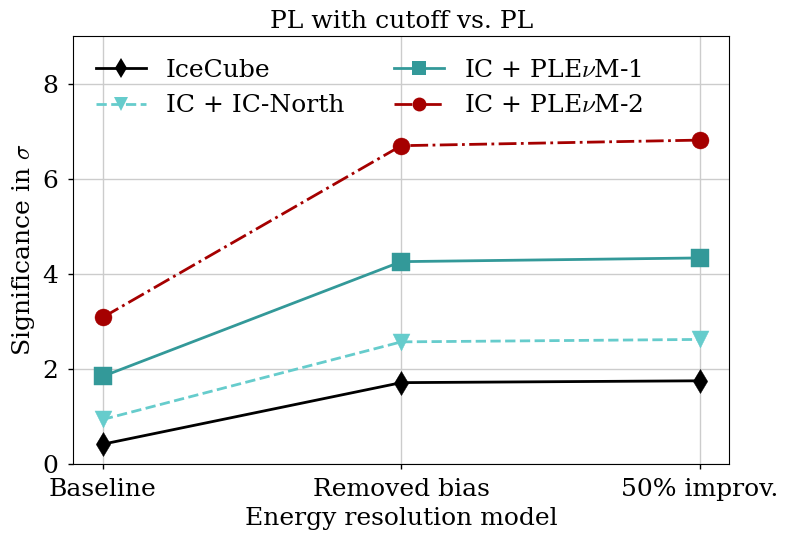

In [37]:
pval_df = pd.read_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))
f, ax = plt.subplots()
for ident, series in pval_df.groupby("key"):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=det_plotting[ident]["ls"],
        color=det_plotting[ident]["color"],
        marker=det_plotting[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[det_plotting[ident]["color"]],
        s=150,
        zorder=10,
        marker=det_plotting[ident]["marker"],
    )

ax.set_ylim(0, 9)
ax.legend(loc=2, ncol=2, frameon=False)  # , fontsize="large")
ax.set_title("PL with cutoff vs. PL")  # , fontsize=18)
ax.set_xlabel("Energy resolution model")  # , fontsize=18)
ax.set_ylabel(r"Significance in $\sigma$")  # , fontsize=18)
f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/cutoff_sigma_vs_eres_ngc.pdf"))

## spectral fit vs. dec

scan for right threshold

In [38]:
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-90, 91, step=5)
num = 20

thresholds = [sigma3, 0.01, 0.1]
tmp = []
for ident in detector_keys:
    conf = st.detector_configurations[ident]
    
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_cut_flux
        )

        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)

        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm,
            )

            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_multi(
                x, shape="powerlaw with cutoff", **dct
            )
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(0, 10), (0, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, Gamma_cut, logE_cut),
                approx_grad=True,
            )
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_sig": np.sum(current_k_s),
                "out_bg": out_bckg,
                "out_comp": out_comp,
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [03:25<00:00,  5.55s/it]


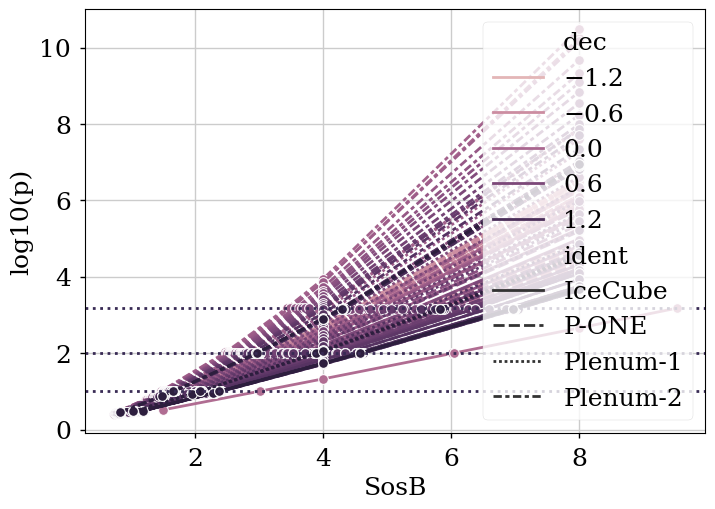

In [39]:
thresholds = [sigma3, 0.01, 0.1]
xname = "SosB"  # "scaler" #
ax = sns.lineplot(data=df, y="log10(p)", x=xname, marker="o", hue="dec", style="ident")
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend()

## plotting


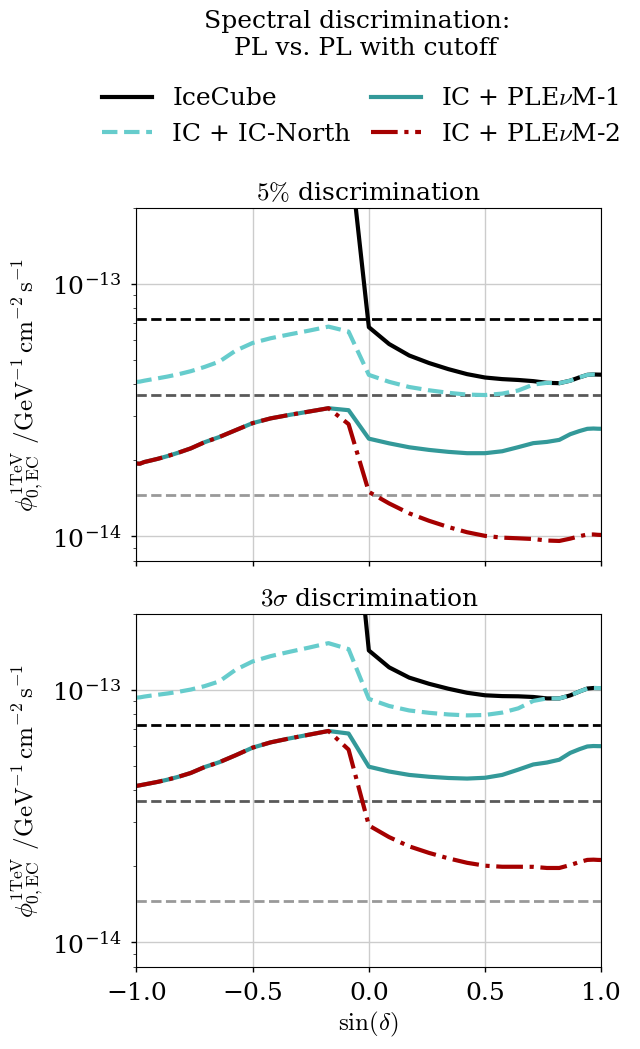

In [40]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01))
    * ngc_cut_flux.norm
)
flux["5%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05))
    * ngc_cut_flux.norm
)
flux["10%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
)
flux = flux.reset_index()

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
        fontsize=18,
    )
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.8)
f.suptitle("Spectral discrimination: \n PL vs. PL with cutoff", fontsize=18)
f.savefig(
    join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot.pdf"), bbox_inches="tight"
)

# Further Checks

## Time scaling

Check how the discovery potential scales with time - see pointsource_analysis.ipynb

## Significance with improved PSF
We model the improved PSF simply with a background norm reduction. This implies that the shape of the PSF stays the same, but it's a reasonable estimate.

### find the characteristic angular scale

(0.0, 3.0)

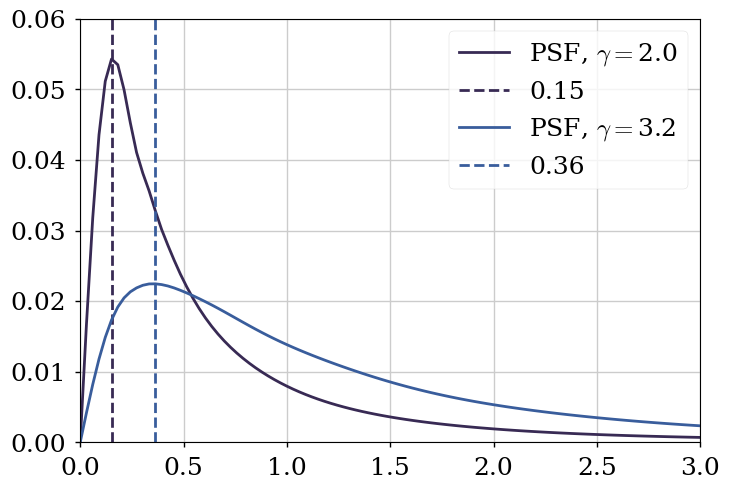

In [41]:
aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
psi_eval = np.linspace(0, 3, num=100)
modes = {}
for gamma in [2.0, 3.2]:
    tmp_flux = PL_flux(1e-14, gamma, 1e3, "powerlaw")

    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=10**aeff_factor_signal.bin_mids[1],
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=tmp_flux,  # powerlaw
    )
    # transform from psi^2 back to psi to get an characteristic angular scale
    spl = InterpolatedUnivariateSpline(k_s.bin_mids[0], k_s.sum(axis=1))
    psf = 2 * psi_eval * spl(psi_eval**2)
    psf /= np.sum(psf)
    p = plt.plot(psi_eval, psf, label=rf"PSF, $\gamma=${gamma}")
    modes[gamma] = psi_eval[np.argmax(psf)]
    plt.axvline(
        modes[gamma], label=f"{modes[gamma]:1.2f}", ls="--", color=p[0].get_color()
    )
plt.legend()
plt.ylim(0, 0.06)
plt.xlim(0, 3)

### scale the BG down to mimic a better PSF

Idea:
* background scales quadratically with the analysis window radius
* a scale of 1 corresponds to the standard PSF
* a wider PSF requires a larger search window, so to first order, we assume that a wider or slimmer PSF can be approximated as a larger or smaller background rate
* as the search window is somewhat like a 2D circle, the background rate scales quadratically
* we neglect e.g. effects by a change in background rate within the search window

In [42]:
detector_keys = ["IceCube", "P-ONE", "Plenum-1"]
psf_scale = np.logspace(-0.6, 1, num=20)
psf_scale = np.sort(np.concatenate([[1], psf_scale]))
results = []

for ident, psf_s in product(detector_keys, psf_scale):
    conf = st.detector_configurations[ident]
    bg_r = psf_s**2  # background scales quadratically with the analysis window radius
    # a scale of 1 corresponds to the standard PSF
    # a wider PSF requires a larger search window
    # so to first order, we assume that a wider or slimmer PSF can be approximated as a larger or smaller background rate
    # as the search window is somewhat like a 2D circle, the background rate scales quadratically
    # we neglect e.g. effects by a change in background rate within the search window
    cur_bg_conf = ngc_bg_config.copy()
    cur_bg_conf["livetime"] *= bg_r
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        energy_reso["baseline"],  # select one resolution for all data sets
        conf,
        bg_config=cur_bg_conf,
        sig_config=ngc_src_config,
        src_flux=ngc_flux
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )
    # fix signal contribution to 0 for background fit
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    results.append(
        {
            "significance": significance,
            "pval": pval,
            "ident": f"IC + {ident}" if ident == "P-ONE" else ident,
            "bg_reduction": bg_r,
            "psf_improvement": psf_s,
        }
    )
results = pd.DataFrame(results)

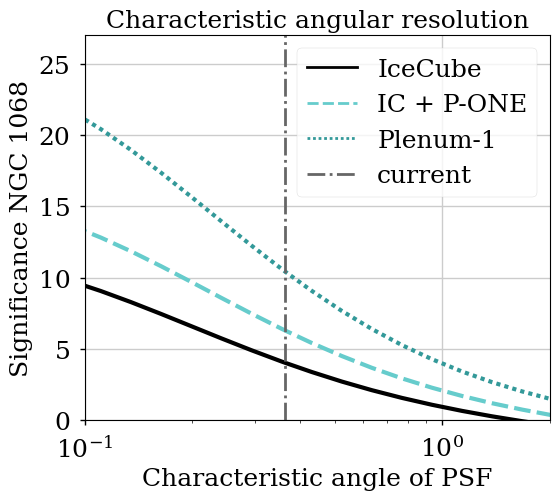

In [43]:
results["characteristic_ang"] = modes[3.2] * results["psf_improvement"]
plt.figure(figsize=(6, 5))
ax = sns.lineplot(
    data=results,
    x="characteristic_ang",
    y="significance",
    style="ident",
    hue="ident",
    lw=3,
    palette=[det_plotting[ident]["color"] for ident in idents],
)
plt.axvline(modes[3.2], label="current", color="0.4", lw=2, ls="-.")
ax.set_xscale("log")
ax.set_xlim(0.1, 2)
ax.set_ylim(0, 27)
plt.legend(loc=1)
legend = ax.get_legend()
legend.set_title(None)
ax.set_title("Characteristic angular resolution")
ax.set_ylabel("Significance NGC 1068")
ax.set_xlabel("Characteristic angle of PSF")
plt.savefig(join(BASEPATH, "plots/ngc_paper/angular_improvement.pdf"))